In [ ]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context(font_scale=1.2,context='paper')
sns.set_context({"figure.figsize": (12, 12)})

from msm_a7_nachrs.manuscript.manuscript import *

In [ ]:
import pandas as pd
from random import seed
import random as rm
import itertools
import pyemma

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import mdshare  # for trajectory data

from tqdm.notebook import tqdm  # progress bar
import seaborn as sns  # for plotting

In [ ]:
import deeptime
deeptime.__version__

In [ ]:
class Dimer(object):
    def __init__(self, index):
        self.index = index
        self._trajectory_states = []
        self._state = self.states[0]
    
    def state_to_features(self):
        if self._state == "CC":
            return np.asarray([0.9, 0.1, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "OC":
            return np.asarray([0.1, 0.9, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "CO":
            return np.asarray([0.9, 0.1, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "OO":
            return np.asarray([0.1, 0.9, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "CD":
            return np.asarray([0.9, 0.1, 0.6, 0.1, 0.4, 0.6])
        elif self._state == "OD":
            return np.asarray([0.1, 0.9, 0.6, 0.1, 0.4, 0.6])
        elif self._state == "DC":
            return np.asarray([0.1, 0.4, 0.6, 0.9, 0.1, 0.6])
        elif self._state == "DO":
            return np.asarray([0.1, 0.4, 0.6, 0.1, 0.9, 0.6])
        elif self._state == "DD":
            return np.asarray([0.1, 0.4, 0.6, 0.1, 0.4, 0.6])
            
        
    def run(self, step):
        self._trajectory = np.zeros([step, 6])
        
        # Init state CC
        self._state = self.states[0]
        self._trajectory_states.append(self.state) 
        self._trajectory[0] = self.state_to_features()
        
        for i in range(1, step):
            if i % 5 == 0:
                self.propagate()
                
            self._trajectory_states.append(self.state) 
            self._trajectory[i] = self.state_to_features()

            
        noise = np.random.normal(0, .01, self._trajectory.shape)
        self._trajectory = self._trajectory + noise
        
    @property
    def state(self):
        return self._state
    
    @property
    def trajectory(self):
        return self._trajectory
    
    @property
    def trajectory_states(self):
        return self._trajectory_states
    
    def propagate(self):
        state_ind = self.states.index(self.state)
        transition = np.random.choice(self.transitionName[state_ind],
                                      replace=True,
                                      p=self.transitionMatrix[state_ind])
        self._state = transition.split('_')[1]
        
    # The statespace
    states = ["CC","OC","CO", "OO", "CD", "OD", "DC", "DO", "DD"]
    
    single_states = ["C", "O", "D"]


    # Possible sequences of events
    transitionName = [["CC_CC", "CC_OC", "CC_CO", "CC_OO", "CC_CD", "CC_OD", "CC_DC", "CC_DO", "CC_DD"],
                      ["OC_CC", "OC_OC", "OC_CO", "OC_OO", "OC_CD", "OC_OD", "OC_DC", "OC_DO", "OC_DD"],
                      ["CO_CC", "CO_OC", "CO_CO", "CO_OO", "CO_CD", "CO_OD", "CO_DC", "CO_DO", "CO_DD"],
                      ["OO_CC", "OO_OC", "OO_CO", "OO_OO", "OO_CD", "OO_OD", "OO_DC", "OO_DO", "OO_DD"],
                      ["CD_CC", "CD_OC", "CD_CO", "CD_OO", "CD_CD", "CD_OD", "CD_DC", "CD_DO", "CD_DD"],
                      ["OD_CC", "OD_OC", "OD_CO", "OD_OO", "OD_CD", "OD_OD", "OD_DC", "OD_DO", "OD_DD"],
                      ["DC_CC", "DC_OC", "DC_CO", "DC_OO", "DC_CD", "DC_OD", "DC_DC", "DC_DO", "DC_DD"],
                      ["DO_CC", "DO_OC", "DO_CO", "DO_OO", "DO_CD", "DO_OD", "DO_DC", "DO_DO", "DO_DD"],
                      ["DD_CC", "DD_OC", "DD_CO", "DD_OO", "DD_CD", "DD_OD", "DD_DC", "DD_DO", "DD_DD"],
                     ]

    # Probabilities matrix (transition matrix)
    transitionMatrix = [[0.6, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  #CC
                        [0.1, 0.3, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0],  #OC
                        [0.1, 0.0, 0.3, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0],  #CO
                        [0.0, 0.1, 0.1, 0.4, 0.0, 0.2, 0.0, 0.2, 0.0],  #OO
                        [0.2, 0.0, 0.1, 0.0, 0.2, 0.1, 0.0, 0.0, 0.4],  #CD
                        [0.0, 0.3, 0.0, 0.1, 0.2, 0.2, 0.0, 0.0, 0.2],  #OD
                        [0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.2, 0.1, 0.4],  #DC
                        [0.0, 0.0, 0.3, 0.1, 0.0, 0.0, 0.2, 0.2, 0.2],  #DO
                        [0.0, 0.0, 0.0, 0.0, 0.15, 0.1, 0.15, 0.1, 0.5] #DD
                       ]

In [ ]:
glic_dimer = Dimer(0)

In [ ]:
glic_dimer.run(50000)

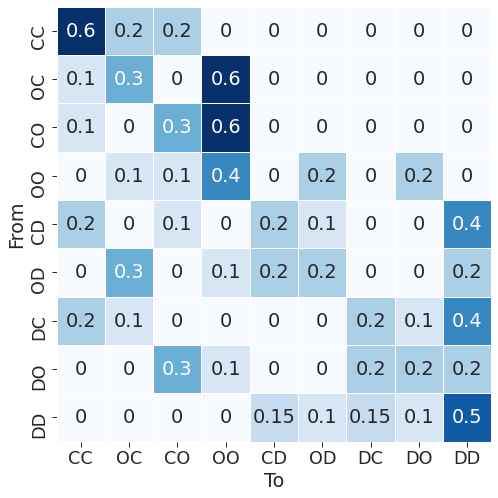

In [236]:
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(glic_dimer.transitionMatrix,
            ax=ax,
            xticklabels=glic_dimer.states,
            yticklabels=glic_dimer.states,
            annot=True,
            cmap="Blues",
            cbar=False,
            square=True,
            linewidths=0.5,
            )

ax.set_xlabel("To")
ax.set_ylabel("From")
plt.savefig("assets/transition_matrix_dimer.pdf", dpi=300, transparent=True)

In [ ]:
from typing import Optional, List
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

class MultimerTrajectoriesDataset(TrajectoriesDataset):
    def __init__(self, multimer: int, data: List[TrajectoryDataset]):
        self.multimer = multimer
        super().__init__(data)

    @staticmethod
    def from_numpy(lagtime, multimer, data: List[np.ndarray]):
        assert isinstance(data, list)
        assert len(data) > 0 and all(data[0].shape[1:] == x.shape[1:] for x in data), "Shape mismatch!"

        data_new = []
        total_shape = data[0].shape[1]
        per_shape = int(total_shape / multimer)

        for i in range(multimer):
            data_new.extend(
                [np.roll(traj.reshape(traj.shape[0], multimer, per_shape),
                                                i, axis=1).reshape(traj.shape[0],total_shape)
                for traj in data])
        return MultimerTrajectoriesDataset(multimer, [TrajectoryDataset(lagtime, traj) for traj in data_new])

In [ ]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

data = [glic_dimer.trajectory.astype(np.float32)]
dataset = MultimerTrajectoriesDataset.from_numpy(5, 2, data)

In [ ]:
from deeptime.decomposition import TICA

tica = TICA(var_cutoff=None, lagtime=5)

tica.fit(dataset)

tica_output= tica.transform(dataset)
tica_concatenated= np.concatenate(tica_output)

tica_model_tica = tica.fetch_model()

In [ ]:
feature = dataset.trajectories[0]
feature_transformed = tica.transform(feature)
fig, axes = plt.subplots(1, 2, figsize=(16,8))
sns.scatterplot(
            x=feature_transformed[:, 0],
            y=feature_transformed[:, 1],
            hue=glic_dimer.trajectory_states,
            s=50, alpha=1, ax=axes[0], legend=False)

axes[0].set_xlabel("TIC 1")
axes[0].set_ylabel("TIC 2")
sns.scatterplot(
            x=feature_transformed[:, 0],
            y=feature_transformed[:, 3],
            hue=glic_dimer.trajectory_states,
            s=50, alpha=1, ax=axes[1])

axes[1].set_xlabel("TIC 1")
axes[1].set_ylabel("TIC 3")

for ax in axes:
    set_axis_boarder(ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("assets/tica_dimer.pdf", dpi=300, transparent=True)

In [ ]:
for i in range(6):
    fig, ax = plt.subplots(figsize=(6,1))
    sns.heatmap(tica_model_tica.instantaneous_coefficients.T[i].reshape(1, -1),
                ax=ax,
                linewidths=0.5,
                cbar=False,
                xticklabels='',
                yticklabels='',
                vmax=1.5,
                vmin=-1.5)
    plt.savefig(f"assets/dimer_tica_{i}.pdf", dpi=300, transparent=True)

In [ ]:
from msm_a7_nachrs.tica.sym_tica import SymTICA

symtica = SymTICA(symmetry_fold=2, var_cutoff=0.8, lagtime=5, scaling=None)

symtica.fit(dataset)

symtica_output= symtica.transform(dataset.trajectories[0])
symtica_concatenated= np.concatenate(symtica_output)

In [ ]:
symtica_model_tica = symtica.fetch_model()

In [ ]:
feature = dataset.trajectories[0]
feature_transformed = np.real(symtica.transform(feature))
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.scatterplot(
            x=feature_transformed[:, 0],
            y=feature_transformed[:, 1],
            hue=glic_dimer.trajectory_states,
            s=50, alpha=1, ax=ax, legend=False)

ax.set_xlabel("Sym TIC 1")
ax.set_ylabel("Sym TIC 2")
#plt.legend(loc='upper right')
plt.tight_layout()
set_axis_boarder(ax)
plt.savefig("assets/dimer_sym_tica.pdf", dpi=300, transparent=True)

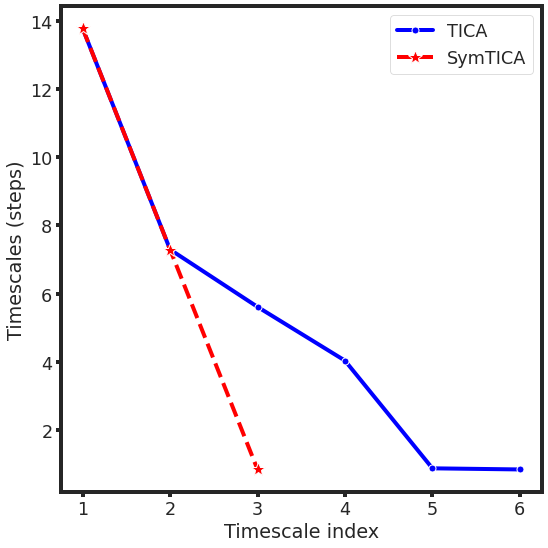

: 

In [237]:
fig, ax = plt.subplots(figsize=(8,8))
n_timescales=100

ax.plot(np.arange(1, tica_model_tica.timescales(k=n_timescales).shape[0]+1),
        tica_model_tica.timescales(k=n_timescales),
             marker='o',
             linestyle='-',
             linewidth=4,
             color='blue',
             markersize=7,
             markeredgecolor='white',
             label='TICA')
ax.plot(np.arange(1, symtica_model_tica.timescales(k=n_timescales).shape[0]+1),
             symtica_model_tica.timescales(k=n_timescales),
             marker='*',
             linestyle='--',
             linewidth=4,
             color='red',
             markersize=15,
             markeredgecolor='white',
            label='SymTICA')


ax.set_ylabel('Timescales (steps)')
ax.set_xlabel('Timescale index')
set_axis_boarder(ax)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("assets/dimer_timescales.pdf", dpi=300, transparent=True)

In [ ]:
from deeptime.clustering import KMeans, RegularSpace

kmean = KMeans(
                n_clusters=6,
                init_strategy='kmeans++',
                max_iter=300,
                n_jobs=24,
                progress=tqdm)

In [ ]:
cluster = kmean.fit(symtica_output).fetch_model()

In [ ]:
dtrajs = cluster.transform(symtica_output)

In [ ]:
its = pyemma.msm.its(dtrajs, lags=10, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='step', dt=1);

In [ ]:
from deeptime.markov import TransitionCountEstimator
lag = 5
from deeptime.markov.msm import BayesianMSM, MaximumLikelihoodMSM

counts = TransitionCountEstimator(lagtime=lag,
                                        count_mode='effective').fit_fetch(dtrajs)
msm = BayesianMSM(n_samples=100).fit(counts)

msm_model = msm.fetch_model()

from deeptime.markov.tools.analysis import stationary_distribution

pi_samples = []
traj_weights_samples = []
for sample in msm_model.samples:
    pi_samples.append(stationary_distribution(sample.transition_matrix))
    traj_weights_samples.append(sample.compute_trajectory_weights(dtrajs))

pi_samples = np.array(pi_samples, dtype=object)
traj_weights_samples = np.array(traj_weights_samples, dtype=object)

stationary_distribution = np.mean(pi_samples, axis=0)
pi = stationary_distribution
trajectory_weights = np.mean(traj_weights_samples, axis=0)

In [ ]:
n_states = 6

lagtimes = np.arange(1, 7+1) * lag

print('Estimating lagtimes', lagtimes)

models = []
for lagtime in tqdm(lagtimes, desc='lagtime', total=len(lagtimes)):
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(dtrajs)
    models.append(BayesianMSM(n_samples=100).fit_fetch(counts))

ck_test = models[0].ck_test(models, n_states, progress=tqdm)

In [ ]:
from deeptime.plots import plot_implied_timescales, plot_ck_test

plot_ck_test(ck_test)

In [ ]:
pcca = msm_model.prior.pcca(n_states)

In [ ]:
transition_mean = msm_model.gather_stats('transition_matrix').mean

In [ ]:
transition_mean = msm_model.gather_stats('transition_matrix').std

In [ ]:
degenerate_states = ['CC', 'CO\nOC', 'OO', 'OD\nDO', 'CD\nDC', 'DD']
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(transition_mean[[4,0,2,3,5,1],
                                  :][:,
                                     [4,0,2,3,5,1]],
            ax=ax,
            xticklabels=degenerate_states,
            yticklabels=degenerate_states,
            annot=True,
            cmap="Blues",
            cbar=False,
            square=True,
            linewidths=0.5,
            fmt=".2f",
            )

ax.set_xlabel("From")
ax.set_ylabel("To")
plt.savefig("assets/transition_matrix_dimer_msm.pdf", dpi=300, transparent=True)

In [ ]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

In [ ]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *symtica_output[:, :2].T, metastable_traj, ax=ax, zorder=-1)
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.1f step',
    arrow_labels=mfpt,
    size=10,
    show_frame=True,
    state_labels=['1','2','3','4', '5', '6'],
    ax=ax)

fig.tight_layout()

In [ ]:
degenerate_states = ['CC', 'CO\nOC', 'OO', 'OD\nDO', 'CD\nDC', 'DD']
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(msm.transition_matrix[[4,0,2,3,5,1],
                                  :][:,
                                     [4,0,2,3,5,1]],
            ax=ax,
            xticklabels=degenerate_states,
            yticklabels=degenerate_states,
            annot=True,
            cmap="Blues",
            cbar=False,
            square=True,
            linewidths=0.5,
            fmt=".2f",
            )

ax.set_xlabel("From")
ax.set_ylabel("To")
plt.savefig("assets/transition_matrix_dimer_msm.pdf", dpi=300, transparent=True)